### Different compareTrackers() plot-styles and use-cases

This function displays each of the "diagnostic-plots" that are saved in a Tracker's track_log return data. These plots represent the graphical results of the transformation applied to that frame's data.

These plots are stored as np.array's as they're outputs of cv2 functions. So we can display them as images or operate on their data-structure using image algebra.
 
We'll avoid why/how we got these list-of-frames / list-of-trackers and simply show visually the usefulness of the comparison.

The problems we're tying to solve: in a condensed graphic, display the different results between two trackers. Specific problems that crop up:
 - not all frames have input_score, and the object to track is usually small so we need an ROI-window, but then we need to rely on track_score to position the window. But track_score b/w trackers can vary drastically, so that means the roi's between trackers will be different and therefore we can't compare how they perform in the same region.
 - the track_score might call for roi around a very small portion of the whole ball, but we're interested in the FalseNegative region of the rest of the ball. So we'll need to expand the roi and use expand_factor here.

In [2]:
import pandas as pd
import sqlalchemy
import numpy as np
import os, sys, copy, random, pickle, cv2, math
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append("../")
%load_ext autoreload
%autoreload 2
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState
from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval,
        subprocBatchOutput, cvtPlot, applyTracker,
        roiSelectScoreWindow, multiPlot, compareTrackers)
from IPython.display import display

### Build pre-req's for calling compareTrackers()
need a tracker, configured and initialized; and need a listGS

different prefix for different situation:

 - "list" - GS/Trackers are all 'inputframes' with an input_score
 - "diff" - GS/Trackers don't have an input_score, and are chosen to optimize the disrepancy b/w track_score in algo_enum=2 vs algo_enum=0

In [31]:
DATA_DIR = "../data/misc/books/compare-tracker-gallery-1/"
gs_db = "compareTrackers_orange.db"
diff_db = "compareTrackers_disparateRoi.db"

# build listGS
testDB = DBInterface(os.path.join(DATA_DIR, gs_db))
listGS = [  pickle.loads(record[1])
            for record in testDB.selectAll()]
print 'list frame_indexes=', str([_gs.frameCounter for _gs in listGS])

# build diffGS
testDB = DBInterface(os.path.join(DATA_DIR, diff_db))
diffGS = [  pickle.loads(record[1])
            for record in testDB.selectAll()]
print 'diff frame_indexes=', str([_gs.frameCounter for _gs in diffGS])

# build listTrackers
listTrackers = []
for _algoenum in [0,1,2]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(_algoenum)
    _tracker.setInit(ballColor="orange")
    listTrackers.append(_tracker)
print 'list algo_enums=', str([_tracker.tp_trackAlgoEnum for _tracker in listTrackers])

# build diffTrackers
diffTrackers = []
for _algoenum in [2,0]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(_algoenum)
    _tracker.setInit(ballColor="orange")
    diffTrackers.append(_tracker)
print 'diff algo_enums=', str([_tracker.tp_trackAlgoEnum for _tracker in diffTrackers])

list frame_indexes= [78, 187, 195, 215, 295, 307]
diff frame_indexes= [202, 206, 210, 244, 305]
list algo_enums= [0, 1, 2]
diff algo_enums= [2, 0]


### Control the region-of-interest

use roiSelectFunc and expand_factor to change window size

Play-with / iterate-on value for expand_factor to include more of the image then just the input_score region, say if track is indicating the hand instead of the ball as seen below.

The top frame, marked_frame, is not part of track_log but is generated separately by drawing the results of that gs-object's inputScore (blue) and trackScore (red) data fields. (This can be turned off with bMarkedFrame=False)

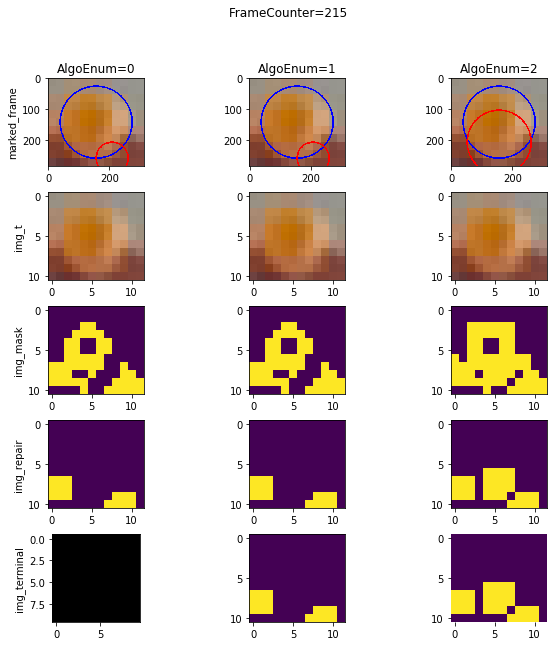

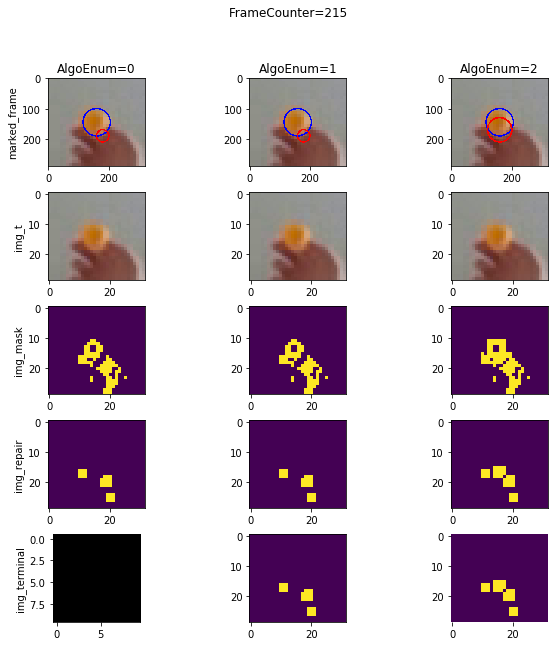

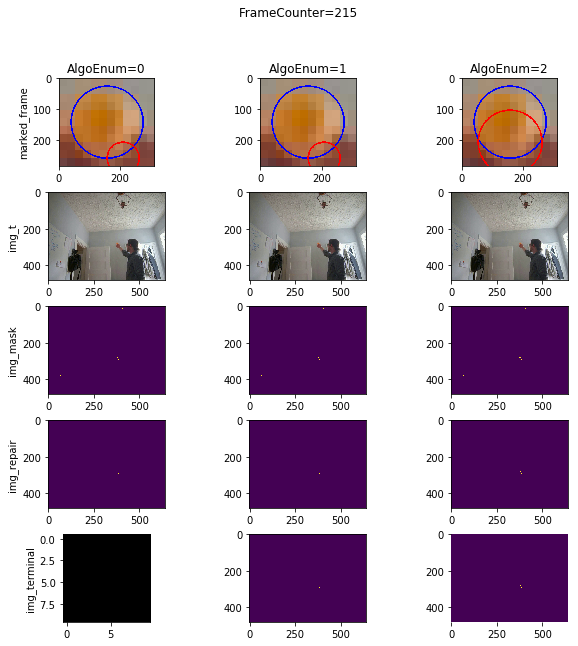

In [32]:
# use roiSelectFunc = roiSelectScoreWindow
compareTrackers([listGS[3]], listTrackers[:3], roiSelectFunc=True)

# use expand_factor
compareTrackers([listGS[3]], listTrackers[:3], roiSelectFunc=True
                ,expand_factor=1.0)

# use roiSelectFunc=False for full frame view
compareTrackers([listGS[3]], listTrackers[:3], roiSelectFunc=False)

### Compare trackers w/o input_score, and divergent track_score
when input_score is available, it makes sense to view all images in this roi. But most frames don't have input_scores so we need to work with track_score to build roi.

use bTrackScore and bFirstTrackerRoi to control in these situations:

In [26]:
from modules.AnalysisHelpers import compareTrackers

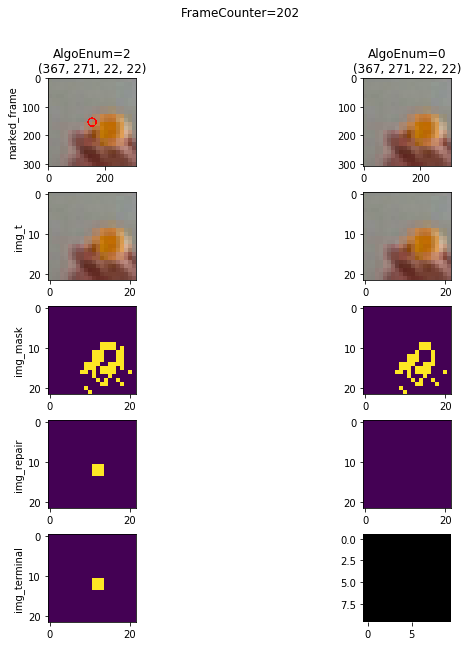

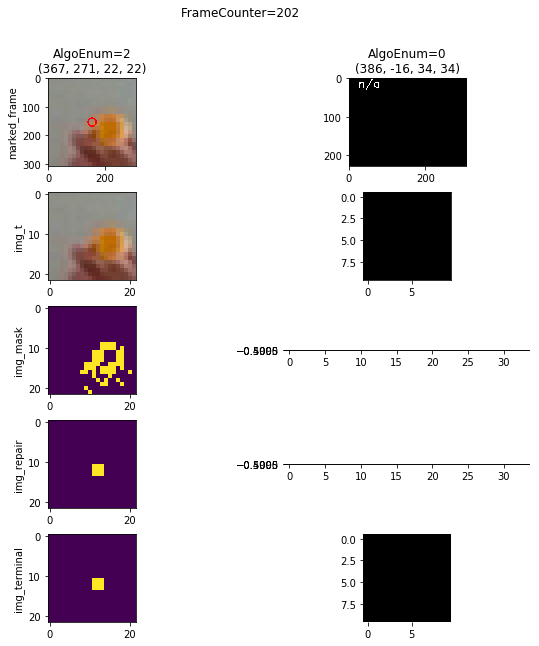

In [33]:
# both columns will have the same window-roi: the roi found from
# the first tracker in listTrackers - this should be the "more correct" one.
compareTrackers([diffGS[0]]
                ,diffTrackers
                ,roiSelectFunc=True
                ,bMarkedFrame=True
                ,bTrackScore=True
                ,bFirstTrackerRoi=True
                ,expand_factor=5.0
               )

# columns will have different window-roi: in this case,
# second column has a non-sensical roi and plots fail to
# be viewable
compareTrackers([diffGS[0]]
                ,diffTrackers
                ,roiSelectFunc=True
                ,bMarkedFrame=True
                ,bTrackScore=True
                ,bFirstTrackerRoi=False
                ,expand_factor=5.0
               )

### Compare trackers with same algo_enum but different paramaters
it works automatically, but we need to overide the default choice to label columns by the algo_enum and instead build out col_titles by hand outside the compareTrackers function

In [8]:
# build new trackers: listParams
ALGO_ENUM = 2
listParams = []
for _param in [1,2,3]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(ALGO_ENUM)
    _tracker.setInit(ballColor="orange")
    _tracker.setTrackParams(repair_iterations=_param)
    listParams.append(_tracker)

print 'repair_iters=', str([_tracker.tp_repair_iterations for _tracker in listParams])

#build col_titles
col_titles = [ ('repair_iters=%s' % str(_tracker.tp_repair_iterations)) 
              for _tracker in listParams]
print col_titles

repair_iters= [1, 2, 3]
['repair_iters=1', 'repair_iters=2', 'repair_iters=3']


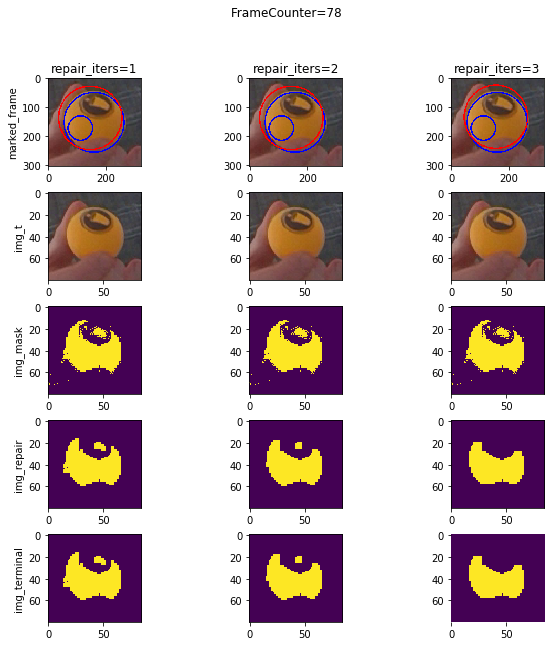

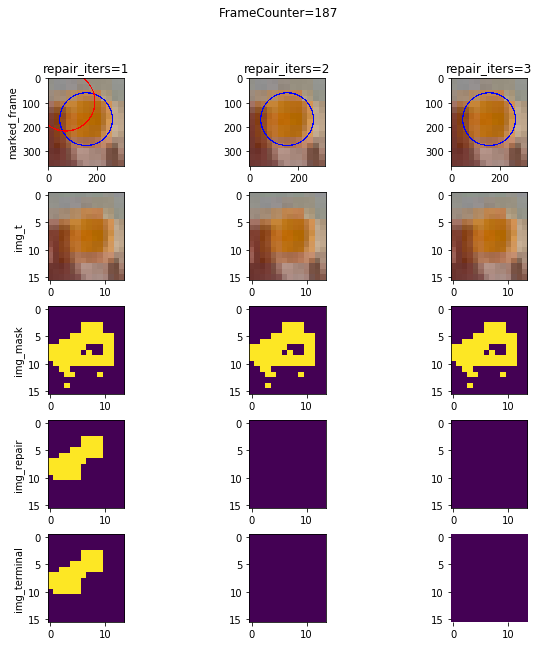

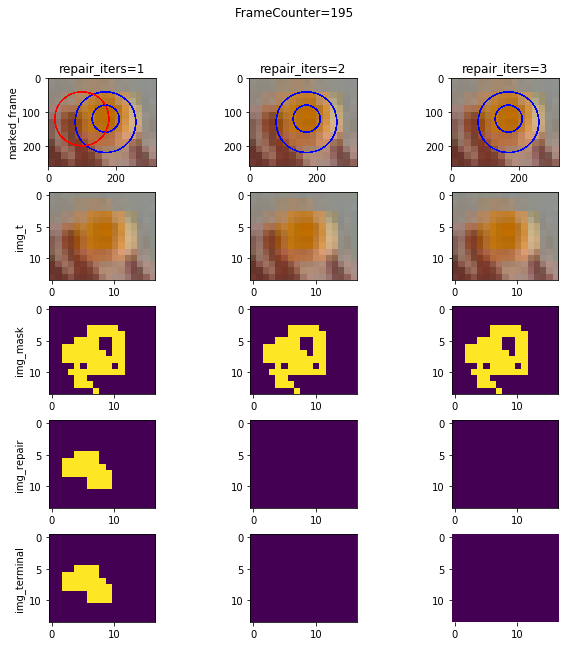

In [9]:
# use expand_factor
# compareTrackers([listGS[3]], listParams[2:], roiSelectScoreWindow, expand_factor=0.3, col_titles = col_titles)
compareTrackers( listGS[:3]
                ,listParams
                ,roiSelectFunc=True
                ,expand_factor=0.3
                ,col_titles=col_titles
               )

### Pass formatting / size options to image display library
use mutliplot_params = {'figsize':(20,20)}

observe how the plot below has tighter width by using wspace param

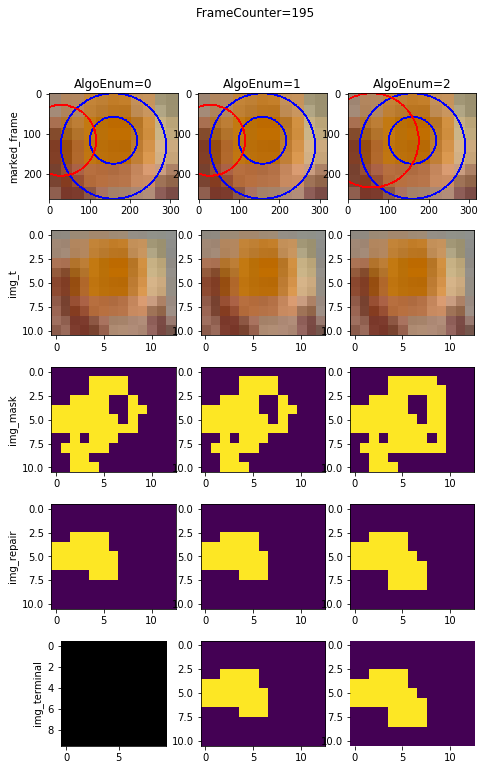

In [10]:
compareTrackers( [listGS[2]]
                ,listTrackers
                ,roiSelectFunc=True
                ,multiplot_params = {'figsize': (8,12), 'wspace': 0.01}                    
               )

### Use test_stub data return to grab an individual image / diagnostic plot as np.array
useing test_stub=True, the plot image is in the return dict in the 'plot_dict' key

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0   255   510   510   510   510   510   510   510
   510   510   510   765  1020  1275  1530  1530  1530  1530  1530  1530
  1530  1530  1785  2040  2040  2040  2295  2550  2550  2550  2550  2550
  2550  2550  2805  3060  3060  3060  3315  3570  3570  3570  3570  3570
  3570  3570  3825  4080  4335  4590  4845  4845  4845  4845  4845  4845
  5100  5355  5610  5865  6120  6375  6630  6630  6630  6885  6885  6885
  7140  7395  7650  7650  7650  7905  7905  7905  7905  8160  8415  8415
  8670  8925  9180  9435  9690  9690  9690  9690  9945 10200 10455 10710
 10710 10710 10710 10710 10965 10965 10965 11220 11475 11730 11985 12240]


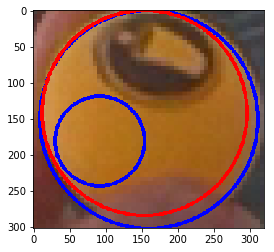

In [12]:
data_dict = compareTrackers([listGS[0]], listTrackers[:3]
                            ,roiSelectFunc=True
                            ,test_stub=True)

# for display
img1 = data_dict['plot_dict']['marked_frame'][0]
cvtPlot(img1)

#for operation /exploration with the data-structure notebook
data_dict2 = compareTrackers( [listGS[3]], listTrackers, roiSelectScoreWindow, test_stub=True)
img_mask = data_dict2['plot_dict']['img_mask'][0]
print img_mask.cumsum()
    

### Compare trackers with different amount/names for diagnostic plots
 - using blennd_rowtitles=True will keep the exact order of diagnostic-plots, whiule listing them separately for each column on the left-axis
 - without that argument, the function will attempt to align plots with the same name while inserting blanks into the column missing that diagnostic plot
 
In the floowing contrived example, we have three extra diagnostic plots in algo_enum=3 then and algo_enum=2. Those plots are: img_dummy, img_dummy_2, img_terminal_2. We want to see how the plots are handled for ordering and labelling vertically.

In [36]:
# build newTrackers
newTrackers = []
for _algoenum in [0,1,2,3]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(_algoenum)
    _tracker.setInit(ballColor="orange")
    newTrackers.append(_tracker)
print 'new algo_enums=', str([_tracker.tp_trackAlgoEnum for _tracker in newTrackers])

new algo_enums= [0, 1, 2, 3]


In [37]:
from modules.AnalysisHelpers import compareTrackers

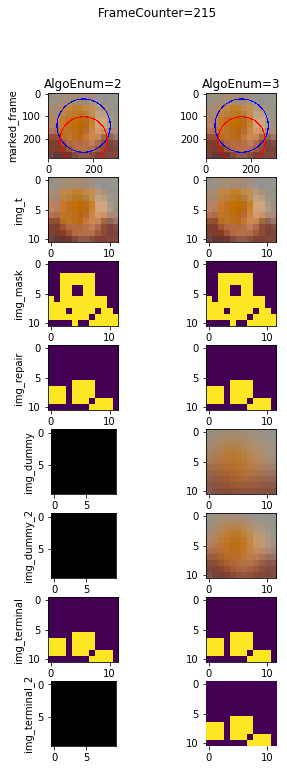

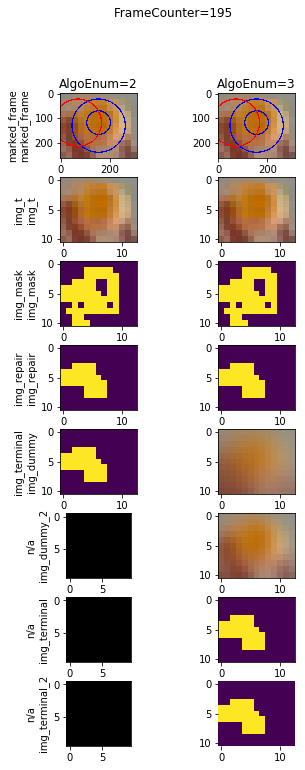

In [38]:
# try to align same-named plots
compareTrackers([listGS[3]], newTrackers[2:], roiSelectFunc=True
                ,multiplot_params = {'figsize': (5,12)})

# label each plot seprately for each column
compareTrackers([listGS[2]], newTrackers[2:], roiSelectFunc=True
                ,blend_rowtitles=True
                ,multiplot_params = {'figsize': (5,12)})